Analyzing Data with Spark - TP 
----------------------
**Master M2 – Université Grenoble Alpes & Grenoble INP

Done By: **BARADZA J. & GASMI A.**


In this notebook, you will find various analysis for a dataset about Google Cluster of 12500 machines for 29 days. We have done thoses analysis using various techniques offered by Apache Spark. 

An overview of the notebook: 

**Part 1:** Importing packages and datasets (RDDs and DataFrames)

**Part 2:** Answering 7 different questions related to the data
    * Questions [1:5] =  using RDD transformations and actions
    * Questions [5]   =  comparing between RDD and PySpark DF (Performance)
    * Questions [5:7] =  using PySpark DF
    * Questions [7]   =  comparing between PySpark DF and Pandas DF
    * Additional Analysis using PySpark DF
    

In [3]:
# importing the necessary packages
import sys
from pyspark import SparkContext
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import timeit
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark import SparkContext

from pyspark.sql.functions import count, avg
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, FloatType, LongType

#### Driver program

# start spark with all available cpus
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

#initial SQLContext for Spark Dataframe manipulations 
sqlContext = SQLContext(sc)

Importing the data in RDDs
--------------------------------------

In [4]:
# read the input file into an RDD[String]

machine_events_rdd = sc.textFile("./data/machine_events.csv")
machine_attributes_rdd = sc.textFile("./data/machine_attributes.csv")
task_events_rdd = sc.textFile("./data/task_events.csv")
job_events_rdd = sc.textFile("./data/job_events.csv")
task_usage_rdd = sc.textFile("./data/task_usage.csv")
task_constraints_rdd = sc.textFile("./data/task_constraints.csv")

machine_events_rdd_col = sc.textFile("./data/machine-events_with_col.csv")
job_events_rdd_all = sc.textFile("./data/al_job-event_with_col.csv")

Importing Spark DataFrames
--------------------------------------

In [5]:
# 1. Machine Events 

# For Spark DF, and because our CSV files don't have a header, we are going to define a schema for the concerned files

schema_machine_events = StructType([
    StructField("time", TimestampType(), True),
    StructField("machine_id", IntegerType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("platform_id", IntegerType(), True),
    StructField("cpus", FloatType(), True),
    StructField("memory", FloatType(), True)])

machine_events_df = sqlContext.read.csv("./data/machine_events.csv",header=False,schema=schema_machine_events)
print("machine events dataframe contains ", machine_events_df.count())

# 1. Task Events DataFrame
schema_task_events = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("missing_info", StringType(), True),
    StructField("job_id", LongType(), True),
    StructField("task_index_job", IntegerType(), True),
    StructField("machine_id", LongType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("username", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("priority", IntegerType(), True),
    StructField("cpu_request", FloatType(), True),
    StructField("memory_request", FloatType(), True),
    StructField("disk_request", FloatType(), True),
    StructField("machine_restriction", IntegerType(), True)])

task_events_df = sqlContext.read.csv("./data/task_events.csv",header=False,schema=schema_task_events)
task_events_df.count()

# 2. Task Usage DataFrame
schema_usage = StructType([
    StructField("start_time", TimestampType(), True),
    StructField("end_time", StringType(), True),
    StructField("job_id", LongType(), True),
    StructField("task_index_job", IntegerType(), True),
    StructField("machine_id", LongType(), True),
    StructField("cpu_rate", IntegerType(), True),
    StructField("canonial_memory", StringType(), True),
    StructField("assigned_memory", IntegerType(), True),
    StructField("unmapped_page_cache", IntegerType(), True),
    StructField("total_page_cache", FloatType(), True),
    StructField("max_memory_usage", FloatType(), True),
    StructField("io_time", FloatType(), True),
    StructField("local_disk_usage", FloatType(), True),
    StructField("max_disk_usage", FloatType(), True),
    StructField("max_io_time", FloatType(), True),
    StructField("cycle_per_inst", FloatType(), True),
    StructField("memory_access", FloatType(), True),
    StructField("sample_portion", FloatType(), True),
    StructField("agg_type", FloatType(), True),
    StructField("cpu_usage", FloatType(), True)])

task_usage_df = sqlContext.read.csv("./data/task_usage.csv",header=False,schema=schema_usage)

# cashing the dataframes for future use
machine_events_df.cache()
task_events_df.cache()
task_usage_df.cache()

machine events dataframe contains  37780


450146

In [6]:
# helping function to "find the index of a specific column in an RDD row"

def findCol(firstLine, name):
    if name in firstLine:
        return firstLine.index(name)
    else:
        return -1

In [7]:
# The first line of the file defines the name of each column in the cvs file
# We store it as an array in the driver program
firstLine = machine_events_rdd_col.filter(lambda x: "timestamp" in x).collect()[0].replace('"','').split(',')
firstLine2 = job_events_rdd_all.filter(lambda x: "time" in x).collect()[0].replace('"','').split(',')

# filter out the first line from the initial RDD
mc_entries = machine_events_rdd_col.filter(lambda x: not ("timestamp" in x))
entries2 = job_events_rdd_all.filter(lambda x: not ("time" in x))

# split each line into an array of items
mc_entries = mc_entries.map(lambda x : x.split(','))
entries2 = entries2.map(lambda x : x.split(','))
#print (entries)


# keep the RDD in memory
mc_entries.cache()
entries2.cache()

# column index of the machine-events rdd
column_index=findCol(firstLine, "event-type")
machine_id =findCol(firstLine, "machine-id")
cpu_index = findCol(firstLine, "capacity-cpu")
ram_index = findCol(firstLine, "capacity-ram")
timestamp=findCol(firstLine, "timestamp")

# column index of the job-events rdd
column_sc =findCol(firstLine2, "scheduling_class")
column_job_id =findCol(firstLine2, "job_id")
column_j_event =findCol(firstLine2, "event_type")


# Using 'map' to create a RDD with all event-type , cpc,scheduling class
events_t = mc_entries.map(lambda x: x[column_index])
sc = entries2.map(lambda x: x[column_sc])

PythonRDD[30] at RDD at PythonRDD.scala:53

PythonRDD[31] at RDD at PythonRDD.scala:53

Answer the questions
-------------------------------

**Question 1**: What is the distribution of the machines according to their CPU capacity?

Here is the distribution of the cpu
 machine with  capacity are : 32  which is = 0.25 % of total machine
 machine with 0.25 capacity are : 126  which is = 1.0 % of total machine
 machine with 0.5 capacity are : 11666  which is = 92.43 % of total machine
 machine with 1.0 capacity are : 798  which is = 6.32 % of total machine


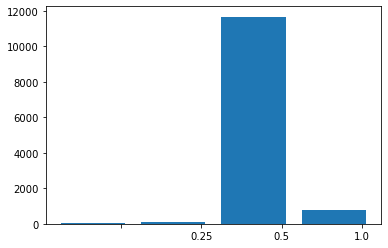

In [7]:
#selecting the machine, their cpu and count the unique distrubiton of each machine per cpu category
perc = mc_entries.map(lambda x : (x[cpu_index],x[machine_id],x[ram_index])).distinct().count()
trimed_rdd = mc_entries.map(lambda x : (x[cpu_index],x[machine_id],x[5])).sortBy(lambda a: a[0]).distinct()
pc = mc_entries.map(lambda x : x[machine_id]).distinct().count()

cpu_capacity = trimed_rdd.map(lambda x: x[0]).countByValue()

print("Here is the distribution of the cpu")

for cpus , count2 in cpu_capacity.items():
  print(" machine with {} capacity are : {}  which is = {} % of total machine".format(cpus, count2 , round(count2*100/perc, 2)))


[valuess [1] for  valuess in cpu_capacity.items()]

data = [valuess [1] for  valuess in cpu_capacity.items()]
lab = [lab[0] for lab  in cpu_capacity.items()]
bar_width = 0.35
indexes = list(range(len(cpu_capacity)))
plt.bar(indexes, data)

#add labels
labelidx = [i + bar_width for i in indexes] 
plt.xticks(labelidx, lab)
plt.show();

*Comments*

The total number of machines in the data center is 12500 machines. The CPU capacity of any machine is categorised into 3 groups and distributed as follows:

a.) The most powerful machines with a CPU capacity  1, there are just 796 machines of this type, which corresponds to 6.32% of the total number of machines. 

b.) Machines with medium CPU capacity, equal to 0.5. These represent the largest number of machines (11666) corresponding to 92.43% of the total number of machines. 

c) The least powerful machines with small CPU capacity, equal to 0.25. There are 126 such machines, which represents 1.0% of the total number of machines.

d.) And finally we found about 32  machine with no category, which is 0.25% of the all machines.


**Question 2**: What is the percentage of computational power lost due to maintenance (a machine went offline and reconnected later)?

In [8]:
trimmed_rdd2 = mc_entries.map(lambda x : (x[cpu_index],x[machine_id],x[ram_index])).distinct()
tr=trimmed_rdd2.map(lambda x: x[2]).countByValue()

for ram , count in tr.items():
     print(" machine with {} ram  are : {}  which is = {} % of total machine".format(ram, count , round(count*100/perc, 2)))


 machine with 0.2493 ram  are : 3866  which is = 30.63 % of total machine
 machine with 0.4995 ram  are : 6732  which is = 53.34 % of total machine
 machine with 0.1241 ram  are : 54  which is = 0.43 % of total machine
 machine with 0.7490000000000001 ram  are : 1003  which is = 7.95 % of total machine
 machine with 0.03085 ram  are : 5  which is = 0.04 % of total machine
 machine with 0.9678 ram  are : 5  which is = 0.04 % of total machine
 machine with 0.2498 ram  are : 126  which is = 1.0 % of total machine
 machine with 0.061579999999999996 ram  are : 1  which is = 0.01 % of total machine
 machine with 1.0 ram  are : 795  which is = 6.3 % of total machine
 machine with  ram  are : 32  which is = 0.25 % of total machine
 machine with 0.5 ram  are : 3  which is = 0.02 % of total machine


**Question 3**: What is the distribution of the number jobs/tasks per scheduling class?

Here is the distribution of jobs per scheduling class
scheduling class 0  has : 257275
scheduling class 1  has : 215110
scheduling class 2  has : 194513
scheduling class 3  has : 5179




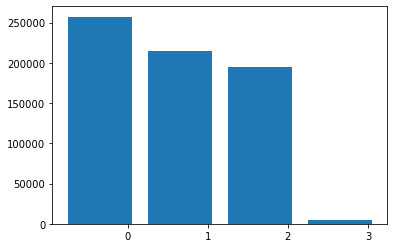

In [9]:
j_sc0 = entries2.map(lambda y : (y[column_job_id],y[column_sc])).distinct()
j_sc=j_sc0.map(lambda y : y[1]).sortBy(lambda a: a[0]).countByValue()

print("Here is the distribution of jobs per scheduling class")
for sc , count3 in j_sc.items():
  print("scheduling class {}  has : {}".format(sc,count3))
print("\n")
data = [lab[1] for lab  in j_sc.items()]
lab = [lab[0] for lab  in j_sc.items()]
bar_width = 0.35
indexes = list(range(len(j_sc)))
plt.bar(indexes, data)

#add labels
labelidx = [i + bar_width for i in indexes] 
plt.xticks(labelidx, lab)
plt.show();

**Question 4**: What is the percentage of jobs/tasks that got killed or evicted depending on the schedulingclass?

Here is the distribution of evicted or killed job per scheduling class
scheduling class 0 has a number of  : 139343 evicted /killed jobs  which is = 51.16 % of total evicted
scheduling class 1 has a number of  : 38867 evicted /killed jobs  which is = 14.27 % of total evicted
scheduling class 2 has a number of  : 89982 evicted /killed jobs  which is = 33.04 % of total evicted
scheduling class 3 has a number of  : 4171 evicted /killed jobs  which is = 1.53 % of total evicted


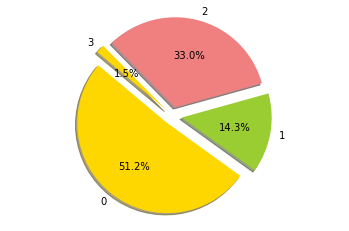

In [10]:
 #number of evicted/killed  task/job per scheduling class.
sumu = entries2.map(lambda w: (w[column_job_id], w[column_j_event], w[column_sc])).filter(lambda w: w[:][1] in ['2' ,'5']).count()
job_evic0 = entries2.map(lambda w: (w[column_job_id], w[column_j_event], w[column_sc])).filter(lambda w: w[:][1] in ['2' ,'5'])

job_evic=job_evic0.map(lambda k : k[2]).sortBy(lambda a: a[0]).countByValue()

print("Here is the distribution of evicted or killed job per scheduling class")
for sc , killed_jobs in job_evic.items():
  print("scheduling class {} has a number of  : {} evicted /killed jobs  which is = {} % of total evicted".format(sc,killed_jobs , round(killed_jobs*100/sumu, 2)))

lab= [sc[0] for sc  in job_evic.items()]
val =[killed_jobs[1] for  killed_jobs in job_evic.items()]
explode = (0.1, 0.1, 0.1, 0.1) 
colors = ['gold', 'yellowgreen', 'lightcoral']
plt.pie(val, explode=explode, labels=lab, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

# explode 1st slice

plt.axis('equal')
plt.show();

Total available Added  : 'Add_0' at initial time: 12583
The machine that were removed due to maintenance : 8957
We notice that during the whole time : 21443 machine were activated  ie:
All rthe Added machine 21443 - 12583 the initialy added we find : 8860 which is the number of reAdded machine after removed
the updated machine are 7380 


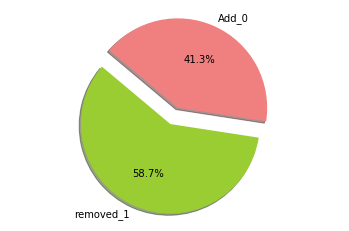

In [10]:
events_0 = mc_entries.map(lambda w : (w[machine_id], w[column_index], w[timestamp])).distinct().filter(lambda x : x[1] in ['0']).map(lambda u: u[0]).distinct().count()

print("Total available Added  : 'Add_0' at initial time: {}".format(events_0))
events_1 = mc_entries.map(lambda w : ( w[machine_id], w[column_index],w[timestamp])).distinct().filter(lambda x : x[1] in ['1']).count()
print("The machine that were removed due to maintenance : {}".format(events_1))
events_00 = mc_entries.map(lambda w : (w[machine_id], w[column_index], w[timestamp])).filter(lambda x : x[1] in ['0']).count()
print("We notice that during the whole time : {} machine were activated  ie:". format(events_00))
print("All rthe Added machine {} - {} the initialy added we find : {} which is the number of reAdded machine after removed".format(events_00,events_0,events_00-events_0))

events_2 = mc_entries.map(lambda w : ( w[machine_id], w[column_index])).filter(lambda x : x[1] in ['2']).count()
print("the updated machine are {} ".format(events_2))

lab= ["removed_1","Add_0"]
val =[events_0, events_00-events_0]
explode = (0.1, 0.1) 
colors = [ 'yellowgreen', 'lightcoral']
plt.pie(val, explode=explode, labels=lab, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

# explode 1st slice

plt.axis('equal')
plt.show();


**Question 5**: Do tasks with low priority have a higher probability of being evicted?
To answer this question, we are going to calculate the probabilty of evicted tasks given they are of a low priority. For that, we will use the Bayes formula P(evicted tasks / low priority tasks). 

As for this question, we are going to do a performance comparison between Spark RDD and Spark DataFrame operations (time of execution). See below.

In [10]:
# split each line into an array of items

start = timeit.default_timer()

task_events = task_events_rdd.map(lambda x: x.split(","))

# supposing that priorities with classes less than 4 are with low priority
low_priority_tasks = task_events.filter(lambda x: x[8] < '4')
num_priority_tasks = low_priority_tasks.count()
num_evicted_tasks = float(low_priority_tasks.filter(lambda x: x[5] == '2').count())
p1 = num_evicted_tasks / num_priority_tasks

print("The probability of evicted task when it is low priority: %.2f percent" %(p1*100))

stop = timeit.default_timer()
print('Execution time for Spark RDD: ', stop - start)  


The probability of evicted task when it is low priority: 1.25 percent
Execution time for Spark RDD:  2.7010788000000048


In [11]:
start = timeit.default_timer()

low_priority_tasks_df = task_events_df.filter((task_events_df.priority < 4))
nbr_low_priority = low_priority_tasks_df.count()                                                          
nbr_evicted_tasks_df = float(low_priority_tasks_df.filter((low_priority_tasks_df["event_type"]==2)).count())

p2 = nbr_evicted_tasks_df / nbr_low_priority

print("The probability of evicted task when it is low priority: %.2f percent" %(p1*100))

stop = timeit.default_timer()
print('Execution time for Spark DF: ', stop - start)  

The probability of evicted task when it is low priority: 1.25 percent
Execution time for Spark DF:  1.5455919999999423


*Comment*

* Results: We can clearly say that the hypothesis (*tasks with low priority have a higher probability of being evicted*) doesn't hold. Only ~1 percent of the evicted tasks are of a low priority 
* Performance: Spark DataFrames is faster thant Spark RDD. It offers high-level domain-specific functionalities. And it uses an optimization engine (Catalyst Optimizer) that helps to save space and reduce execution time. Consequently, we are going to go with Spark DF to answer the next questions and do some analysis. PS: another comparaison between Spark DF and Pandas Dataframes comes in next questions.

**Question 6**: In general, do tasks from the same job run on the same machine?

In [12]:
#select the rows where job_id is not null
task_events = task_events_df.filter(task_events_df.job_id.isNotNull())
task_events.count()
task_events_groupped = task_events_df.groupBy("job_id", "machine_id").agg(count("*")).groupBy("job_id").agg(count("*"))
dfs = task_events_groupped.withColumnRenamed("count(1)", "num_machines")
dfs.show()

450146

+----------+------------+
|    job_id|num_machines|
+----------+------------+
|5554591681|           3|
|6051350394|           2|
|6210690644|         121|
|6251695084|           2|
|6251707278|           2|
|6251711349|           2|
|6251851196|           2|
|6251933641|        1062|
|6238987821|          10|
|5440065284|          36|
|6234228702|           8|
|2509801309|           6|
|6232114040|           1|
|6238968291|           1|
|4645263861|           1|
|5756212140|           1|
|4974913023|           1|
|6058486346|           1|
|4537082914|           2|
|6170713516|           1|
+----------+------------+
only showing top 20 rows



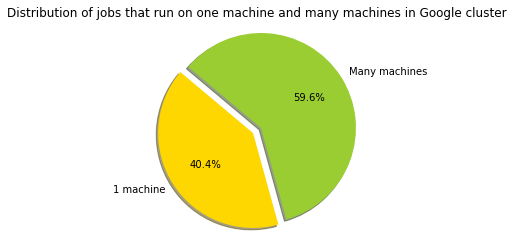

In [13]:
num_1 = dfs.filter((dfs["num_machines"]==1)).count()
total = dfs.count()
#y = task_events_groupped.select("count(1)").rdd.flatMap(lambda x: x).collect()

# Data to plot
labels = '1 machine', 'Many machines'
sizes = [num_1, total-num_1]
colors = ['gold', 'yellowgreen']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Distribution of jobs that run on one machine and many machines in Google cluster')

plt.axis('equal')
plt.show();

As we notice, jobs tend to work on a cluster when needed. After all this is the point of making clusters. 

**Question 7**: Are there tasks that consume significantly less resources than what they requested?

*Significantly less: we take 10% as a threshold for comparison

PS: We are going to (try to) compare the performance between Spark DF and Pandas DF 

In [14]:
# NOTE: for question 7, we are going to compare between the performance of Pyspark DF and Pandas DF (execution time)
start = timeit.default_timer()

# let's filter the tasks that at least used one ressources (or, has a value in the row greater than zero)
task_usage_df = task_usage_df.filter((task_usage_df["cpu_usage"] > 0) | (task_usage_df["assigned_memory"] > 0) | (task_usage_df["local_disk_usage"] > 0))
# simply counting them to check the numbers
task_usage_df.count()
# and joining the filtered dataframe with "task_usage_df" on the ID(job_id,task_index_job) = lots of calculations :/ 
joined_data = task_usage_df.join(task_events_df, ['job_id','task_index_job'])
joined_data.count()

stop = timeit.default_timer()
print('Execution time for Spark DF: ', stop - start)  

91716

222491

Execution time for Spark DF:  29.40220239999985


In [15]:
# let's import again those two dataframes using Pandas

df_task_usage = pd.read_csv("./data/task_usage.csv", names=["start_time","end_time","job_id","task_index_job","machine_id","cpu_rate","canonial_memory","assigned_memory","unmapped_page_cache","total_page_cache","max_memory_usage","io_time","local_disk_usage","max_disk_usage","max_io_time", "cycle_per_inst","memory_access","sample_portion", "agg_type","cpu_usage"])
df_task_events = pd.read_csv("./data/task_events.csv", names=["timestamp","missing_info","job_id","task_index_job","machine_id","event_type","username","scheduling_class","priority","cpu_request","memory_request","disk_request", "machine_restriction"])


<font color='red'><b>*WARNING:*</b></font> 
Executing this block of code will kill the kernel (due to limited ressource allocated for Jupyter)

In [ ]:

start = timeit.default_timer()

# cpu_usage_index=19, assigned_memory_index=7, local_disk_usage_index=12
task_usage_pandas = df_task_usage[(df_task_usage["cpu_usage"] > 0) | (df_task_usage["assigned_memory"] > 0)| (df_task_usage["local_disk_usage"] > 0)]

#joined_date = task_usage_df.join(task_events_df, ['job_id','task_index_job'])

pd_join = pd.merge(task_usage_pandas, df_task_events, on=['job_id','task_index_job'])

pd_join.count()

stop = timeit.default_timer()

print('Time: ', stop - start)  
print('Execution time for Pandas DF: ', stop - start) 

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 37310)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pysp

<font color='red'>*DISCLAIMER*</font>: 
Running the join operation on the dataframes with Pandas using Jupyter Notebook would crash the kernel due to the intensive calculation needed. When we used .py script, it took @1 minute to finish the calculations. Hense, Spark is very efficient at handling intensive calculations. 


In [19]:
# counting the number of tasks within jobs that received less ressources than requested (10% as a threshold)
less_ressources = joined_data.filter((0.1*joined_data["cpu_request"] > joined_data["cpu_usage"] ) & 
                   (0.1*joined_data["memory_request"] > joined_data["assigned_memory"]) &
                   (0.1*joined_data["disk_request"] > joined_data["local_disk_usage"]) ) 
c = less_ressources.count()

In [20]:
print("There is",c,"tasks that received significantly less ressources thant requested")

There is 170925 tasks that received significantly less ressources thant requested


**Other Analysis**
--------------


**1#**: Number of adds(0), removes(1) and updates(2) per machine

This simple analysis has as a goal to show the number of machines given the number of event types (adds, removes and updates). 
We can see that the number of machines added to the cluster are most of the times equal to number of machines removed (same machines then). On the other hand, the number of updates is higher than removes and adds, which makes sense as we usually do updates in the lifecycle of a machine (between adding to removal).

In [21]:
machine_events_dfd = machine_events_df.filter(machine_events_df.machine_id.isNotNull()).groupBy("machine_id","event_type").agg(count("*")).orderBy("event_type",ascending=False)
machine_events_dfd.show()

+----------+----------+--------+
|machine_id|event_type|count(1)|
+----------+----------+--------+
| 400426643|         2|       8|
| 308516669|         2|       6|
|1390772944|         2|       7|
|   6567472|         2|       6|
| 346897607|         2|       2|
| 266853480|         2|       1|
|    682478|         2|       1|
|1478958061|         2|       3|
|1436490084|         2|      37|
| 759604527|         2|       4|
|1458705361|         2|       1|
|   5781221|         2|       4|
|   5781239|         2|       1|
|  16916847|         2|       2|
|1440305526|         2|       5|
| 655986468|         2|       2|
| 294823359|         2|       2|
|  32058404|         2|       1|
| 257412150|         2|       2|
| 288820972|         2|       2|
+----------+----------+--------+
only showing top 20 rows



In [22]:
machine_events_dfd = machine_events_dfd.withColumnRenamed("count(1)", "cpt")
machine_events_type0 = machine_events_dfd.filter((machine_events_dfd["event_type"]==0)).groupBy("cpt").agg(count("*")).orderBy("cpt")
machine_events_type1 = machine_events_dfd.filter((machine_events_dfd["event_type"]==1)).groupBy("cpt").agg(count("*")).orderBy("cpt")
machine_events_type2 = machine_events_dfd.filter((machine_events_dfd["event_type"]==2)).groupBy("cpt").agg(count("*")).orderBy("cpt")
#machine_events_fins =machine_events_dfd.groupBy("event_type").agg({'cpt':'sum'}).orderBy("event_type")

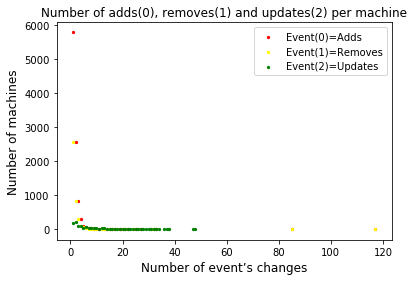

In [23]:
x1 = machine_events_type0.select("cpt").rdd.flatMap(lambda x: x).collect()
y1 = machine_events_type0.select("count(1)").rdd.flatMap(lambda x: x).collect()

x2 = machine_events_type1.select("cpt").rdd.flatMap(lambda x: x).collect()
y2 = machine_events_type1.select("count(1)").rdd.flatMap(lambda x: x).collect()

x3 = machine_events_type2.select("cpt").rdd.flatMap(lambda x: x).collect()
y3 = machine_events_type2.select("count(1)").rdd.flatMap(lambda x: x).collect()

plt.scatter(x1, y1, s=5, c = 'red',label="Event(0)=Adds")
plt.scatter(x2, y2, s=5, c = 'yellow', label="Event(1)=Removes")
plt.scatter(x3, y3, s=5, c = 'green', label="Event(2)=Updates")
plt.legend()
plt.xlabel('Number of event’s changes', fontsize=12)
plt.ylabel('Number of machines', fontsize=12)

plt.title('Number of adds(0), removes(1) and updates(2) per machine')

plt.show();

## **2#**: Number of Jobs per Priority

This is an analysis of the number of jobs per priority in our cluster. As we can see, priority 2 is the highest in numbers in our case followed by 0 then 9.

In [24]:
task_events_pr = task_events_df.filter(task_events_df.job_id.isNotNull()).groupBy("priority").agg(count("*")).orderBy("priority",ascending=False)
task_events_pr.show()

+--------+--------+
|priority|count(1)|
+--------+--------+
|      11|   13087|
|      10|    1688|
|       9|   99178|
|       8|    7013|
|       2|  173736|
|       1|   35733|
|       0|  119711|
+--------+--------+



No handles with labels found to put in legend.


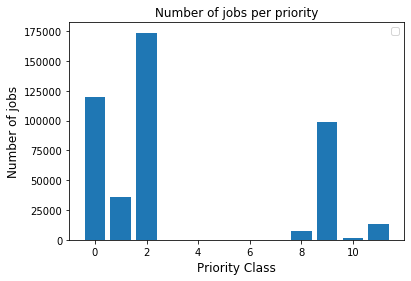

In [25]:
x = task_events_pr.select("priority").rdd.flatMap(lambda x: x).collect()
y = task_events_pr.select("count(1)").rdd.flatMap(lambda x: x).collect()

plt.bar(x, y)
plt.legend()
plt.xlabel('Priority Class', fontsize=12)
plt.ylabel('Number of jobs', fontsize=12)

plt.title('Number of jobs per priority')

plt.show();

In [ ]:
# removing the dataframes from the cache 
machine_events_df.unpersist()
task_events_df.unpersist()
task_usage_df.unpersist()




*Done by BARADZA Jonathan & GASMI Adel.*